<a href="https://colab.research.google.com/github/Moukthika1253/NaiveBayesClassifier-Rotten-Tomato-reviews/blob/main/NBC_Rotten_tomato_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string,re
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.stem import PorterStemmer
import math

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [77]:
rt_df=pd.read_csv('/content/rt_reviews.csv',encoding='latin-1')

# Splitting data into Train-50%, Dev-20%, Test-30%

In [78]:
X_train,X_remaining, y_train, y_remaining= train_test_split(rt_df['Review'],rt_df['Freshness'],train_size=0.5)
X_test, X_dev, y_test, y_dev = train_test_split(X_remaining,y_remaining,test_size=0.3)
train_set=pd.concat([X_train,y_train],axis=1).reset_index(drop=True)
dev_set=pd.concat([X_dev,y_dev],axis=1).reset_index(drop=True)
test_set=pd.concat([X_test,y_test],axis=1).reset_index(drop=True)
print(f"Train set size:  ",train_set.size)
print(f"Dev set size:  ",dev_set.size)
print(f"Test set size:  ",test_set.size)

Train set size:   480000
Dev set size:   144000
Test set size:   336000


In [79]:
train_set.head()

,Review,Freshness
0,Bio-pics always tailor memories. Yet the welc...,fresh
1,"""The Meddler"" is a disappointment after the t...",rotten
2,A sappy subplot involving teenage daughter Pa...,rotten
3,"We're 9 years past the first ""X-Men"" movie an...",rotten
4,"All in all, the gifted (writer-director Chris...",fresh


# Pre-processing

In [80]:
def preprocessing(review):
  stop_words=stopwords.words('english')
  word_lemmatizer=WordNetLemmatizer()
  tokenized_words=[(word) for word in word_tokenize(review)]
  words=[word.lower() for word in tokenized_words if word.lower() not in stop_words]
  for i in range(len(words)):
   words[i]=''.join([word for word in words[i] if word not in (string.punctuation)])
  no_emptywords=[word for word in words if word]
  no_extraspace=[re.sub(r'\s\s+', '',word) for word in no_emptywords]
  lemmatized_words=[word_lemmatizer.lemmatize(word) for word in no_extraspace]
  return lemmatized_words 
  

In [81]:
train_set['Review']=train_set['Review'].apply(preprocessing)
train_set.head()

,Review,Freshness
0,"[biopics, always, tailor, memory, yet, welcome...",fresh
1,"[meddler, disappointment, talent, scafaria, de...",rotten
2,"[sappy, subplot, involving, teenage, daughter,...",rotten
3,"[re, 9, year, past, first, xmen, movie, comput...",rotten
4,"[gifted, writerdirector, christopher, nolan, s...",fresh


**Calculating Total number of words in Vocab**

In [141]:
review_list=[]
for i,review in train_set['Review'].items():
  for word in review:
    review_list.append(word)
review_list=list(set(review_list))
tot_words=len(review_list)
print(f"total number of words in the list: {tot_words}")

total number of words in the list: 86811


In [83]:
pos_reviews=0
neg_reviews=0
num_pos_words=0
num_neg_words=0
pos_words=[]
neg_words=[]
word_dict=defaultdict(lambda:[0,0])
freshness=list(train_set['Freshness'])

# Calculating word frequencies for each word in fresh and rotten review

In [84]:
for i, review in enumerate(list(train_set['Review'])):
  if  freshness[i] == 'fresh':
    pos_reviews=pos_reviews+1
  else:
    neg_reviews=neg_reviews+1
  for word in (review):
    if freshness[i] == 'fresh':
      word_dict[word][1]+=1
      num_pos_words+=1
      pos_words.append(word)
    else:
      word_dict[word][0]+=1
      num_neg_words+=1
      neg_words.append(word)

In [85]:
(word_dict)

defaultdict(<function __main__.<lambda>()>,
            {'biopics': [43, 39],
             'always': [731, 1278],
             'tailor': [14, 20],
             'memory': [347, 513],
             'yet': [1656, 2228],
             'welcome': [328, 520],
             'surprise': [471, 797],
             'kutcher': [54, 23],
             'barefoot': [1, 2],
             'rebel': [40, 42],
             'brought': [180, 230],
             'spirit': [347, 685],
             'psychedelia': [3, 9],
             'technology': [104, 188],
             'meddler': [2, 9],
             'disappointment': [441, 96],
             'talent': [808, 715],
             'scafaria': [10, 1],
             'demonstrated': [22, 7],
             '2012': [77, 73],
             'feature': [1194, 1354],
             'debut': [346, 852],
             'seeking': [65, 120],
             'friend': [388, 368],
             'end': [3100, 2051],
             'world': [1585, 2788],
             'sappy': [125, 38],
         

# Probability calculation

**P(fresh) and P(rotten)**

In [86]:
prob_rotten=train_set['Freshness'].value_counts(normalize=True)['rotten']
prob_fresh=train_set['Freshness'].value_counts(normalize=True)['fresh']
print(f'P(fresh) = {prob_fresh} P(rotten) = {prob_rotten}')

P(fresh) = 0.4994458333333333 P(rotten) = 0.5005541666666666


**P(word)**

In [87]:
def word_alone_prob(word):
  return ((word_dict[word][1]/num_pos_words))+((word_dict[word][0]/num_neg_words))

In [88]:
word_alone_prob('buffay')

6.421601239112176e-07

**P(word|fresh) and P(word|rotten)**

In [89]:
def word_prob(reviewType, word):
  if reviewType == 'fresh':
    return (word_dict[word][1]/num_pos_words)
  else:
    return (word_dict[word][0]/num_neg_words)
  

In [90]:
word_prob('fresh','buffay')

6.421601239112176e-07

In [91]:
word_prob('rotten','buffay')

0.0

**P(fresh|review) and P(rotten|review)**

In [92]:
def withoutSmoothing_probability(reviewType, review):
  if reviewType == 'fresh':
    prob=math.log(pos_reviews/len(rt_df))
  else:
    prob=math.log(neg_reviews/len(rt_df))
  preprocessed_reviews=[]
  preprocessed_reviews=preprocessing(review)
  for word in preprocessed_reviews:
     prob=prob+word_prob(reviewType,word)
  return prob
    

# Class Prediction

In [93]:
def predict_class_withoutSmoothing(sentence):
 if withoutSmoothing_probability('fresh',sentence) > withoutSmoothing_probability('rotten',sentence):
   return "fresh"
 else:
    return "rotten"

# Dev and Test accuracy without Smoothing

In [94]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class_withoutSmoothing(word) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [95]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.5778333333333333


In [131]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class_withoutSmoothing(word) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [132]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.5783988095238095


# Experiments

# Applied Smoothing

**P(word)**

In [98]:
alpha=1
def word_only_prob(word,num_words):
  return (math.log((word_dict[word][1]+alpha)/(num_pos_words+num_words)))+(math.log((word_dict[word][0]+alpha)/(num_neg_words+num_words)))

In [99]:
word_only_prob('buffay',tot_words)

-27.90828119308933

**P(fresh|word) and P(rotten|word)**

In [100]:
def cond_prob(reviewType, word,num_words):
  if reviewType == 'fresh':
    return math.log((word_dict[word][1]+alpha)/(num_pos_words+(num_words)))
  else:
    return math.log((word_dict[word][0]+alpha)/(num_neg_words+(num_words)))

In [101]:
cond_prob('fresh','buffay',tot_words)

-13.619529128466546

**P(fresh|review) and P(rotten|review)**

In [102]:
def review_probability(reviewType, review,n):
  if reviewType == 'fresh':
    prob=math.log(pos_reviews/len(rt_df))
  else:
    prob=math.log(neg_reviews/len(rt_df))
  preprocessed_reviews=[]
  preprocessed_reviews=preprocessing(review)
  for word in preprocessed_reviews:
     prob=prob+cond_prob(reviewType,word,n)
  return prob
    

**Comparing probabilities of fresh and rotten class**

In [103]:
print(review_probability('fresh','Story inspired by historical events that illustrates the process whereby enemies can become friends..',tot_words))
print(review_probability('rotten','Story inspired by historical events that illustrates the process whereby enemies can become friends.',tot_words))

-90.0820095691017
-91.642382986593


**Class prediction**

In [104]:
def predict_class(sentence,n):
 if review_probability('fresh',sentence,n) > review_probability('rotten',sentence,n):
   return "fresh"
 else:
    return "rotten"

In [105]:
predict_class('Story inspired by historical events that illustrates the process whereby enemies can become friends.',tot_words)

'fresh'

# Deriving top 10 words that predict each class

In [106]:
def topmost_prob(pos_word):
  p={}
  for i in range(len(pos_word)):
   num=(cond_prob('fresh',pos_word[i],tot_words))
   p[pos_word[i]]=num
  return p

In [107]:
def topmost_negprob(neg_word):
  p={}
  for i in range(len(neg_word)):
   num=(cond_prob('rotten',neg_word[i],tot_words))
   p[neg_word[i]]=num
  return p

**Top 10 words that predict class=Fresh**

In [108]:
p=topmost_prob(pos_words)
top10_words=sorted(p.items(),key=lambda x:x[1],reverse=True)
print("Top 10 words         P[class='fresh'|word]")
for i, (k,v) in enumerate(top10_words[:10]):
 print(k,"                    ", v)


Top 10 words         P[class='fresh'|word]
s                      -3.483839180127862
film                      -4.218940366880423
movie                      -4.678179930498655
one                      -5.024079439084541
nt                      -5.090012187361476
story                      -5.343643458992189
like                      -5.41144595691571
make                      -5.462588702336925
performance                      -5.620186175753264
time                      -5.717411582190098


**Top 10 words that predict class=Rotten**

In [109]:
p=topmost_negprob(neg_words)
top10_words=sorted(p.items(),key=lambda x:x[1],reverse=True)
print("Top 10 words         P[class='rotten'|word]")
for i, (k,v) in enumerate(top10_words[:10]):
 print(k,"                    ", v)

Top 10 words         P[class='rotten'|word]
s                      -3.510608604989785
film                      -4.393901705482322
movie                      -4.43392968406794
nt                      -4.547077808249263
like                      -5.026578544006587
one                      -5.1804444182117555
story                      -5.45121601851522
much                      -5.464368334366726
make                      -5.486680728087503
character                      -5.5366448662934244


 **Accuracy on dev dataset**

In [111]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class(word,tot_words) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [112]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.8006111111111112


**Testing on Test dataset**

In [113]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class(word,tot_words) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [114]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.7970535714285715


# After removing rare words (occurence<5)

In [142]:
word_dict_copy=word_dict.copy()
count=0
for i, (k,v) in enumerate(word_dict_copy.items()):
  if (v[0]<5 and v[1]<5):
    del(k)
    count+=1

In [143]:
print(f"Total number of rare words: {count}")
no_rarewords=tot_words-count

Total number of rare words: 71922


In [144]:
print(f'Total number of words after removing rarewords: {no_rarewords}')

Total number of words after removing rarewords: 14889


**Accuracy on dev dataset**

In [145]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class(word,no_rarewords) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [146]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.7875


**Accuracy on Test dataset**

In [147]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class(word,no_rarewords) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [148]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.7843809523809524


# Considering small dataset where total number of words=7000

**Selecting first 7000 most frequent occuring words from vocabulary**

In [151]:
word_dict = sorted(word_dict.items(),  key=lambda x : x[1][0] + x[1][1], reverse=True)[:7000]

In [152]:
word_dict = defaultdict(lambda: [0, 0], word_dict)

**Dev Accuracy**

In [153]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class(word,15000) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [154]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.7745


**Test Accuracy**

In [155]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class(word,15000) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [156]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.7725833333333333


# Comparing Dev and Test accuracies across different models

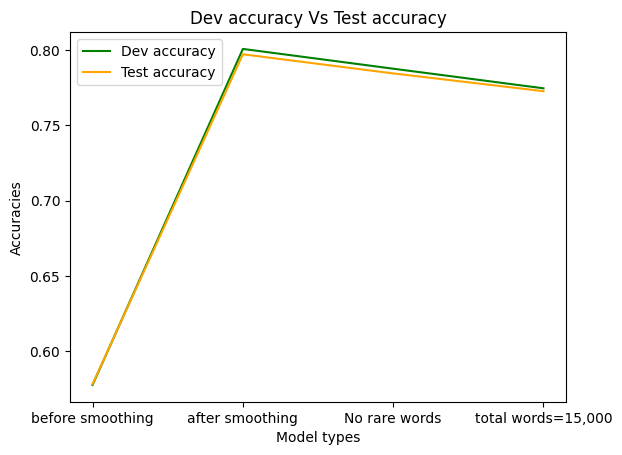

In [157]:
accuracies_dev=[0.5778333333333333,0.8006111111111112, 0.7875, 0.7745]
accuracies_test=[0.5783988095238095,0.7970535714285715, 0.7843809523809524,0.7725833333333333]
types=["before smoothing","after smoothing","No rare words","total words=15,000"]
import matplotlib.pyplot as plt
plt.title("Dev accuracy Vs Test accuracy")
plt.plot(types,accuracies_dev,'g',label="Dev accuracy")
plt.plot(types,accuracies_test,'orange',label="Test accuracy")
plt.xlabel('Model types')
plt.ylabel('Accuracies')
plt.legend()
plt.show()